# Pipelining and `BlockSpec`s

In this guide we'll cover how memory spaces in TPU work and how to write pipelines in Pallas that overlap memory I/O with compute.

In [ ]:
#@title Imports

import jax
from jax.experimental import pallas as pl
import jax.numpy as jnp
import numpy as np

## TPU and its memory spaces

A TPU and its TensorCore consist of memory spaces (where arrays can reside), registers (which temporarily store scalar and array values) and compute units (that do computation with values in registers). Below is a diagram of a TPU in which `x` and `y` are arrays that live in high-bandwidth memory (HBM):

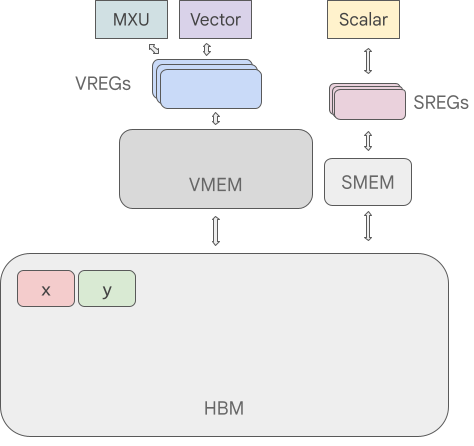

Let's talk about the components of this diagram in more detail:

* **Memory spaces**: A TPU has high-bandwidth memory (HBM) which is what we often think of as "device memory". There is also vector memory (VMEM), a cache meant for storing vector and array values, and scalar memory (SMEM), a cache designed to store scalar values.
* **Registers**: A TensorCore has two main types of registers: vector registers (VREGs) store array values, and scalar registers (SREGs) store scalar values. Values can be loaded into memory from their respective caches (VMEM for VREGs and SMEM for SREGs).
* **Compute units**: A TensorCore has a scalar unit, vector unit (VPU) and matrix unit (MXU) that can do numerical computation. Compute units operate on values that live in SREGs and VREGs and output values into those registers as well.

In order to do a vectorized computation on our values `x` and `y` that live in HBM, we need to:

1. Copy the values `x` and `y` into VMEM.
2. Load the values from VMEM into VREGs.
3. Execute the computation using the VPU or MXU, storing the output in VREGs.
4. Store the values in the output VREGs into VMEM.
5. Copy the output values in VMEM back to HBM.

Let's implement a Pallas function that does just that!

In [ ]:
def add_matrices_kernel(x_vmem_ref, y_vmem_ref, z_vmem_ref):
  # Load x and y from VMEM into VREGs
  x_vregs = x_vmem_ref[:, :]
  y_vregs = y_vmem_ref[:, :]
  # Execute a vectorized add
  z_vregs = x_vregs + y_vregs
  # Store the output values in VREGs back into VMEM
  z_vmem_ref[:, :] = z_vregs


def add_matrices(x: jax.Array, y: jax.Array) -> jax.Array:
  # pallas_call will first allocate scratch buffers for `x` and `y` in VMEM.
  # It will then copy `x` and `y` from HBM into VMEM.
  z = pl.pallas_call(
      add_matrices_kernel, out_shape=jax.ShapeDtypeStruct(x.shape, x.dtype)
  )(x, y)
  # pallas_call will also copy the output from VMEM back into HBM.
  return z


x, y = jnp.ones((512, 512)), jnp.ones((512, 512))
add_matrices(x, y)

Array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

We've written two functions: `add_matrices_kernel` and `add_matrices`.

`add_matrices_kernel` operates using `Ref`s that live in VMEM. Loading from a VMEM `Ref` produces a value that lives in VREGs. Values in VREGs behave like `jax.Array`s in that we can use `jnp` and `jax.lax` operations on them to produce new values that live in VREGs. When we produce the values we'd like to return, we store them in the output VMEM `Ref`.

The `add_matrices` function acts on `jax.Array`s and returns a `jax.Array`. Inside it, we pass `x` and `y` into `pallas_call`. `pallas_call` is responsible for copying `x` and `y` into VMEM and for allocating the VMEM buffers that the kernel operates on (including allocating `z_vmem_ref`, the output VMEM buffer). After the kernel function is finished running, `pallas_call` will also copy the value in `z_vmem_ref` to HBM, resulting in an output `jax.Array`.

## Constraints of using VMEM/SMEM

Pallas exposes access to lower level memory spaces like VMEM and SMEM but writing kernels utilizing them adds some considerations.

1. Memory capacity. VMEM and SMEM are *small*! VMEM on v4 TPUs is only 16MiB and SMEM ranges in the tens to hundreds of KiB. If our arrays are too big, we won't even be able to fit them into VMEM at all. For reference, a `f32[2048, 2048]` array is 16MiB, so our above kernel won't scale beyond moderately sized arrays.

2. Memory bandwidth. Copying to/from HBM and VMEM takes a long time, at least compared to most compute instructions. The `add_matrices` function above will likely spend more time copying between HBM and VMEM than actually performing the addition itself.

With these two constraints in mind, we'll have to rethink our strategy for getting performance out of our TPUs.

## Primer: Pipelining

Pipelining our computation offers a way of dealing with both the memory capacity and bandwidth constraints in one fell swoop. What do we mean by pipelining?

The goal is: *in parallel* copy to/from HBM and VMEM *while* utilizing our compute units. Naively this is difficult because in our program above we copy *all* of `x` and `y` before we start doing any compute with them, creating a dependence between the copy and the compute.

However, if we can chunk up our computation into several subcomputations (e.g. when we add two matrices, we can express that as addition of "blocks" of the original matrices together), we can now overlap the copies of one of those subcomputations with the compute of the other. Let's walk through a simple example:

Let's say we split our arrays `x` and `y` into `x1, x2` and `y1, y2` (for example, split along the leading axis, resulting in two `(256, 512)` arrays for each input. We can now execute the following pipelined computation.

1. Copy `x1` and `y1` into VMEM.
1. Start copying `x2` and `y2` into VMEM
2. Load `x1, y1` from VMEM into VREGs.
3. Execute the `z1 = x1 + y1` using the compute units.
4. Store `z1` into VMEM.
5. Start copying `z1` from VMEM back into HBM.
6. Wait until `x2, y2` have been copied into VMEM.
7. Load `x2, y2` from VMEM into VREGs.
8. Execute the `z2 = x2 + y2` using the compute units.
9. Store `z2` into VMEM.
10. Wait until `z1` is copied into HBM.
10. Start copying `z2` from VMEM back into HBM.
10. Wait until `z2` is copied into HBM.

Any time we are doing compute here, we are asynchronously copying something. This means that some of the time spent copying is not wasted.

The two most important numbers for determining how efficient a pipelined computation are a) how many floating point operations (FLOPs) we need to execute and b) how many bytes we need to copy to execute that computation. The ratio of these two (FLOPs/memory usage) is called the *arithmetic intensity* of an operation and determines if our pipeline will be compute bound or memory bound.

## Pipelining in Pallas

How do we implement a pipeline like the one above in Pallas? It seems like a complex sequence of asynchronous data operations and executing kernels that would be a pain to implement manually. Fear not! Pallas offers an API for expressing pipelines without too much boilerplate, namely through `grid`s and `BlockSpec`s.

### `grid`, a.k.a. kernels in a loop

See how in the above pipelined example, we are executing the same logic multiple times: steps 3-5 and 8-10 both execute the same operations, only on different inputs. The generalized version of this is a loop in which the same kernel is executed multiple times. `pallas_call` provides an option to do exactly that.

The number of iterations in the loop is specified via the `grid` argument to `pallas_call`. Conceptually:
```python
pl.pallas_call(some_kernel, grid=n)(...)
```
maps to
```python
for i in range(n):
  # do HBM -> VMEM copies
  some_kernel(...)
  # do VMEM -> HBM copies
```
Grids can be generalized to be multi-dimensional, corresponding to nested loops. For example,

```python
pl.pallas_call(some_kernel, grid=(n, m))(...)
```
is equivalent to
```python
for i in range(n):
  for j in range(m):
    # do HBM -> VMEM copies
    some_kernel(...)
    # do VMEM -> HBM copies
```
This generalizes to any tuple of integers (a length `d` grid will correspond to `d` nested loops).

### `BlockSpec`, a.k.a. how to chunk up inputs

The next piece of information we need to provide Pallas in order to automatically pipeline our computation is information on how to chunk it up. Specifically, we need to provide a mapping between *the iteration of the loop* to *which block of our inputs and outputs to be operated on*. A `BlockSpec` is exactly these two pieces of information.

 First we pick a `block_shape` for our inputs. In the pipelining example above, we had `(512, 512)`-shaped arrays and split them along the leading dimension into two `(256, 512)`-shaped arrays. In this pipeline, our `block_shape` would be `(256, 512)`.

We then provide an `index_map` function that maps the iteration space to the blocks. Specifically, in the aforementioned pipeline, on the 1st iteration we'd like to select `x1` and on the second iteration we'd like to use `x2`. This can be expressed with the following `index_map`:

```python
def x_index_map(i):
  return (i, 0)
```

We'd then construct the `BlockSpec`:
```python
block_spec = pl.BlockSpec(x_index_map, (256, 512))
```

The `BlockSpec`s for `y` and `z` will be the same as the one for `x`.

### Putting it together

We provide these arguments to `pallas_call` via `grid`, `in_specs` and `out_specs` (`in_specs` corresponds to the tuple of positional arguments, and `out_specs` corresponds to the output).

In [ ]:
def add_matrices_pipelined(x: jax.Array, y: jax.Array) -> jax.Array:
  block_spec = pl.BlockSpec(lambda i: (i, 0), (256, 512))
  return pl.pallas_call(
      add_matrices_kernel,
      out_shape=x,
      in_specs=[block_spec, block_spec],
      out_specs=block_spec,
      grid=(2,))(x, y)

add_matrices_pipelined(x, y)

Array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

We've only added a little bit of code to our original function to add automatic pipelining but the `BlockSpec`s and `grid` do a lot of heavy lifting!

How does it work? Well, the `BlockSpec`s provide enough information to start *prefetching* blocks of our input from HBM into VMEM. For example, if we are starting iteration `i` of our `grid`, we can pass `i + 1` into the `index_map` functions to obtain the blocks needed for the next iteration. We can then start an asynchronous copy for those blocks. Similarly for outputs, we can wait for the outputs of the previous iteration to be copied before starting the copy for the current iteration's outputs.

### Parameterizing a pipeline

It's common to parameterize the block shapes in our kernel. Block sizes are perhaps the most important parameter to tune when optimizing the performance of Pallas kernels! They give us control over the pipeline (for example, picking smaller blocks adds more iterations to our pipelined loop where each iteration has less work to do).

Furthermore, we could also carve up the inputs and outputs along the 2nd dimension (we are only splitting along the first right now). Let's write a more general kernel that handles both of these features.

In [ ]:
def add_matrices_pipelined_2d(
    x: jax.Array, y: jax.Array, *, bm: int = 256, bn: int = 256
) -> jax.Array:
  m, n = x.shape
  block_spec = pl.BlockSpec(lambda i, j: (i, j), (bm, bn))

  return pl.pallas_call(
      add_matrices_kernel,
      out_shape=x,
      in_specs=[block_spec, block_spec],
      out_specs=block_spec,
      grid=(m // bm, n // bn),
  )(x, y)


np.testing.assert_array_equal(
    add_matrices_pipelined_2d(x, y, bm=256, bn=256), x + y
)
np.testing.assert_array_equal(
    add_matrices_pipelined_2d(x, y, bm=128, bn=128), x + y
)
np.testing.assert_array_equal(
    add_matrices_pipelined_2d(x, y, bm=512, bn=512), x + y
)

## Handling reductions

How would you implement something like `jnp.sum` using `pallas_call`? Specifically, we'd like to pipeline across the reduction dimension.

Take the example of reducing a `(8, 512, 512)`-shaped array to a `(512, 512)`-shaped one.

In [ ]:
x = jnp.ones((8, 512, 512))
jnp.sum(x, axis=0)

Array([[8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       ...,
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.]], dtype=float32)

To do this using `pallas_call`, we could use a grid of size `(8,)` and in each iteration `i` load `x[i]` into VMEM. Then we could add `x[i]` to an output VMEM buffer. Let's implement this naively first.

In [ ]:
# Warning: this implementation is incorrect!

def naive_sum_kernel(x_ref, o_ref):
  o_ref[...] += x_ref[...]

def naive_sum(x: jax.Array) -> jax.Array:
  grid, *out_shape = x.shape
  return pl.pallas_call(
      naive_sum_kernel,
      grid=grid,
      # None in `block_shape` means we pick a size of 1 and squeeze it away
      in_specs=[pl.BlockSpec(lambda i: (i, 0, 0), (None, *out_shape))],
      out_specs=pl.BlockSpec(lambda i: (0, 0), out_shape),
      out_shape=jax.ShapeDtypeStruct(out_shape, x.dtype)
      )(x)
naive_sum(x)

Array([[9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       ...,
       [9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.],
       [9., 9., 9., ..., 9., 9., 9.]], dtype=float32)

Notice how we've set up the `BlockSpec`s: we're loading the entirety of the `(512, 512)` dimension into VMEM (no pipelining there) but selecting the `i`-th dimension of `x` each iteration in the `index_map`. We are using a `None` for that dimension in the block shape, which indicates that we are selecting a singleton dimension from `x` that we would like to squeeze away in the kernel. Therefore, `x_ref` is `(512, 512)`-shaped in VMEM as well.

`out_spec` uses `lambda i: (0, 0)` as its `index_map`, indicating that `o_ref` is unchanged over the course of the pipeline. This means that we can update its value each iteration by reading from and writing to it. Or can it? Actually there is one catch: *`o_ref` is initially garbage*, meaning we'll be accumulating into garbage. This will result in the overall function outputting the incorrect value!

Therefore, **whenever we do a reduction in a kernel, we need to make sure to initialize the `Ref` that is storing the reduced value**. We can accomplish this by conditionally writing a value to `out_ref` when we're on iteration 0. We can do this with the helper function `pl.when`, a convenience wrapper around `jax.lax.cond`, and `pl.program_id`, which queries which iteration in a grid axis we are in.

In [ ]:
def sum_kernel(x_ref, o_ref):
  @pl.when(pl.program_id(axis=0) == 0)
  def _():
    o_ref[...] = jnp.zeros_like(o_ref)

  o_ref[...] += x_ref[...]

def sum(x: jax.Array) -> jax.Array:
  grid, *out_shape = x.shape
  return pl.pallas_call(
      sum_kernel,
      grid=grid,
      # None in `block_shape` means we pick a size of 1 and squeeze it away
      in_specs=[pl.BlockSpec(lambda i: (i, 0, 0), (None, *out_shape))],
      out_specs=pl.BlockSpec(lambda i: (0, 0), out_shape),
      out_shape=jax.ShapeDtypeStruct(out_shape, x.dtype)
      )(x)
sum(x)

Array([[8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       ...,
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.]], dtype=float32)

This `sum` function now outputs the correct values!

One last thing to note about reductions in Pallas are that **they must be done in the minormost (rightmost) dimensions of our grid** (our grid is 1-dimensional in the above example so we are reducing over its minormost dimension). This is because the pipeline that Pallas generates using the `BlockSpec`s, `grid` and kernel function *does not read outputs back from HBM*. Once you've written an output value back to HBM you cannot revisit it. Therefore, you cannot do a reduction across a grid dimension that has any revisiting and therefore all reductions need to happen in the rightmost dimensions.

## TPUs in Megacore configuration

Some TPU chips have two TensorCores but appear as one device to JAX users. This is called "megacore". The separate TensorCores have their own separate VMEM, VREGs, SMEM, SREGs and compute units but *share HBM*.

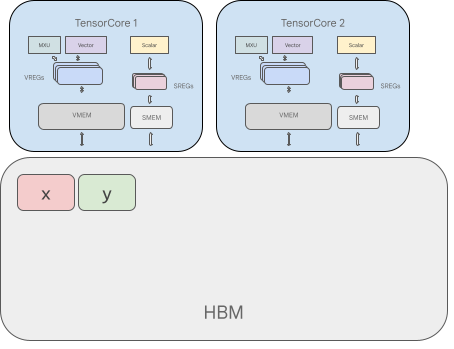

Conceptually, TPUs in Megacore behave like very simple GPUs, i.e. they have only two threads. How do we modify our kernels to utilize both TensorCores simultaneously?

The basic idea is that if we have embarrassingly parallel dimensions in our computation, we can split up those dimensions across the TensorCores. We can indicate which dimensions are parallelizable by providing an annotation to `pallas_call` called `dimension_semantics`.

In [ ]:
def add_matrices_pipelined_megacore(x: jax.Array, y: jax.Array) -> jax.Array:
  block_spec = pl.BlockSpec(lambda i: (i, 0), (256, 512))
  return pl.pallas_call(
      add_matrices_kernel,
      out_shape=x,
      in_specs=[block_spec, block_spec],
      out_specs=block_spec,
      grid=(2,),
      compiler_params=dict(mosaic=dict(dimension_semantics=("parallel",))))(
        x, y)

x, y = jnp.ones((512, 512)), jnp.ones((512, 512))
add_matrices_pipelined_megacore(x, y)

Array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

`dimension_semantics` should be a tuple of same length as `grid` where each entry is either `"parallel"` or `"arbitrary"`. `"parallel"` indicates to Pallas that the iterations of the for loop corresponding to that dimension can be executed independently without affecting the correctness of the program. `"arbitrary"` indicates to Pallas that there can be no assumptions made about this grid dimension and it therefore cannot be parallelized.

By specifying `dimension_semantics`, we now execute the kernel simultaneously on each TensorCore. Pallas will handle splitting up the grid automatically.

> Note that Megacore is only currently available on TPU `v4` and TPU `v5p`. Supplying `dimension_semantics` annotations is a no-op on other platforms, but *not* specifying it will result in only one TensorCore being used (even if there are more than one available).

## Conclusion

In this guide we covered how to express TPU pipelines using `pallas_call`, `grid` and `BlockSpec`s. We covered how to express nested loops via a multi-dimensional grid and how to handle reductions by initialize our accumulators at the beginning of the reduction. We also learned how to handle Megacore by adding annotations to the kernel.

Exercises left to the reader:
* Try implementing a `sum` kernel that pipelines the other dimensions as well
* Add megacore support to the `add` kernel and the `sum` kernel as well.